# Recurrent Neural Network in PyTorch on a Synthetic Dataset
## CPE 490 590 Spring 2024
### Author: Rahul Bhadani

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import math

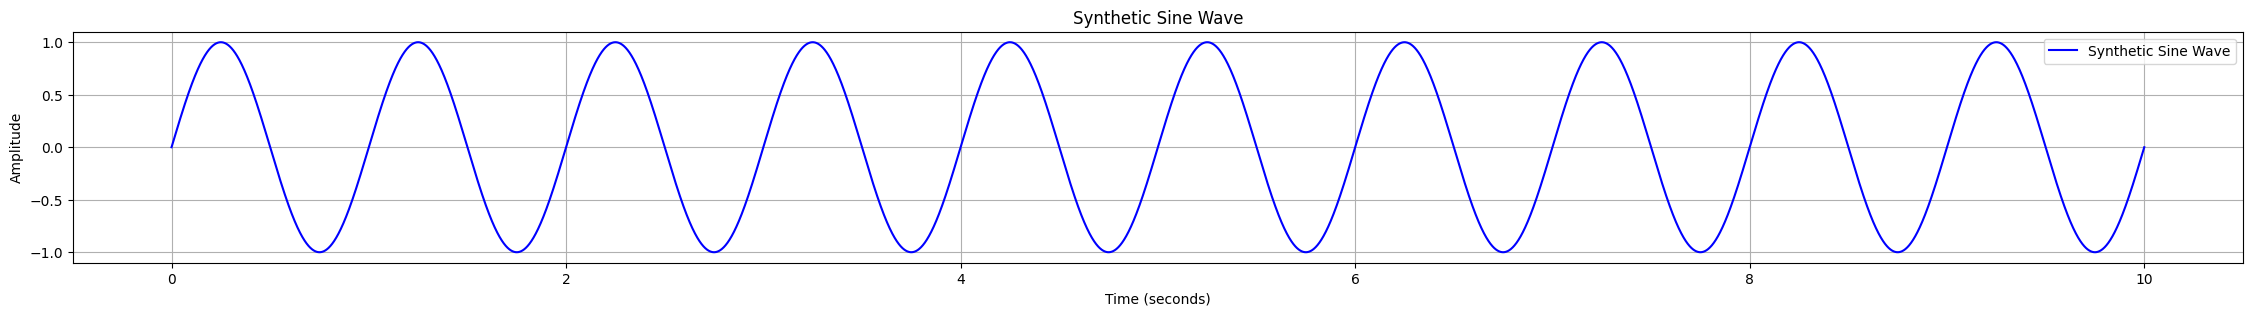

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a synthetic sine wave
freq = 1  # Frequency of the sine wave (in Hz)
duration = 10  # Duration of the sine wave (in seconds)
sampling_rate = 1000  # Sampling rate (number of samples per second)

# Generate time values
time = np.linspace(0, duration, int(sampling_rate * duration))

# Generate the sine wave
amplitude = 1.0  # Amplitude of the sine wave
sine_wave = amplitude * np.sin(2 * np.pi * freq * time)

# Create a DataFrame with 'ds' (time) and 'y' (sine wave values)
dataset = pd.DataFrame({'ds': time, 'y': sine_wave})

# Plot the synthetic sine wave
plt.figure(figsize=(28, 3))  # Increase the size of the plot
plt.plot(dataset['ds'], dataset['y'], label='Synthetic Sine Wave', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Synthetic Sine Wave')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
dataset.shape

(10000, 2)

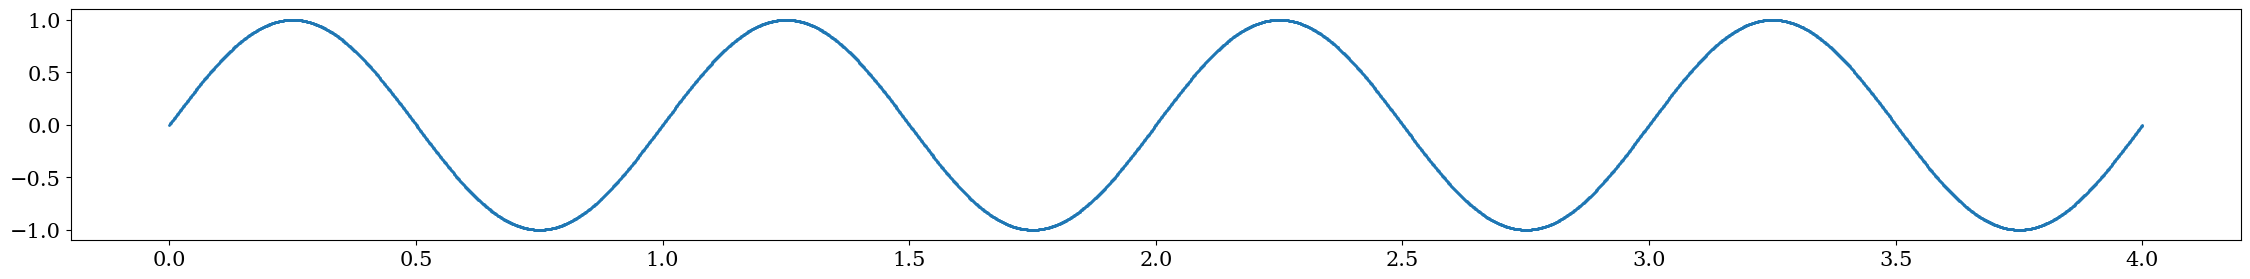

In [6]:
plt.rcParams['font.family'] = 'Serif'
plt.rcParams['font.size'] = 15

# Create the plot
plt.figure(figsize=(28, 3))  # Increase the size of the plot

plt.scatter(dataset['ds'].iloc[0:4000], dataset['y'].iloc[0:4000], s= 1)

In [8]:
dataset.head()

,ds,y
0,0.000,0.000000
1,0.001,0.006284
2,0.002,0.012567
3,0.003,0.018850
4,0.004,0.025133


In [9]:
training_data_len = math.ceil(len(dataset) * .8)
training_data_len
 
#Splitting the dataset
train_data = dataset[:training_data_len]
test_data = dataset[training_data_len:]
print(train_data.shape, test_data.shape)

(8000, 2) (2000, 2)


In [10]:
dataset_train = train_data.y.values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(8000, 1)

In [11]:
# Selecting Open Price values
dataset_test = test_data.y.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1))
dataset_test.shape

(2000, 1)

In [12]:
dataset_test

array([[ 5.02702978e-03],
       [ 1.13106235e-02],
       [ 1.75937705e-02],
       ...,
       [-1.25672965e-02],
       [-6.28377233e-03],
       [-2.44929360e-15]])

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)

print(scaled_train[:5])
# Normalizing values between 0 and 1
scaled_test = scaler.transform(dataset_test)
print(*scaled_test[:5]) #prints the first 5 rows of scaled_test


[[0.49999998]
 [0.50314186]
 [0.50628362]
 [0.50942514]
 [0.51256628]]
[0.50251349] [0.50565529] [0.50879686] [0.51193809] [0.51507884]


In [14]:
# Create sequences and labels for training data
sequence_length = 48 # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
	X_train.append(scaled_train[i:i+sequence_length])
	y_train.append(scaled_train[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape


(torch.Size([7952, 48, 1]), torch.Size([7952, 48, 1]))

In [15]:
# Create sequences and labels for testing data
sequence_length = 30 # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
	X_test.append(scaled_test[i:i+sequence_length])
	y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape


(torch.Size([1970, 30, 1]), torch.Size([1970, 30, 1]))

In [16]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        out, _ = self.rnn(x)
        # out shape: (batch_size, sequence_length, hidden_size)
        out = self.linear(out[:, -1, :])  # Take the last time step's output
        # out shape: (batch_size, 1)
        return out

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [18]:
input_size = 1
num_layers = 2
hidden_size = 256
output_size = 1

# Define the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print(model)


RNNModel(
  (rnn): RNN(1, 256, num_layers=2, batch_first=True)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)


In [19]:
batch_size = 128
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for batch training
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [20]:
num_epochs = 100
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
	total_loss = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)

		# print(batch_y.shape)
		# print(predictions.shape)

		y_batch = batch_y[:, -1, :]  # Take the last time step's value
		y_batch = y_batch.view(-1, 1)  # Shape: (batch_size, 1)
		
		loss = loss_fn(predictions, y_batch)
		

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	print("{}. Total Loss: {}".format(epoch, total_loss))

	# Calculate average training loss and accuracy
	average_loss = total_loss / len(train_loader)
	train_hist.append(average_loss)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_test_loss = 0.0

		for batch_X_test, batch_y_test in test_loader:
			batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
			predictions_test = model(batch_X_test)

			y_test_batch = batch_y_test[:, -1, :]  # Take the last time step's value
			y_test_batch = y_test_batch.view(-1, 1)  # Shape: (batch_size, 1)

			test_loss = loss_fn(predictions_test, y_test_batch)

			total_test_loss += test_loss.item()

		# Calculate average test loss and accuracy
		average_test_loss = total_test_loss / len(test_loader)
		test_hist.append(average_test_loss)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


0. Total Loss: 5.321250768349273
1. Total Loss: 0.023079206395777874
2. Total Loss: 0.009404123615240678
3. Total Loss: 0.00875219931913307
4. Total Loss: 0.008285563002573326
5. Total Loss: 0.007907889950729441
6. Total Loss: 0.007397495639452245
7. Total Loss: 0.006717868309351616
8. Total Loss: 0.006329459785774816
9. Total Loss: 0.005841912927280646
Epoch [10/100] - Training Loss: 0.0001, Test Loss: 0.0001
10. Total Loss: 0.0054526805397472344
11. Total Loss: 0.0049909212393686175
12. Total Loss: 0.004836358697502874
13. Total Loss: 0.004500143255427247
14. Total Loss: 0.003958686975238379
15. Total Loss: 0.0037273724847182166
16. Total Loss: 0.003331644915306242
17. Total Loss: 0.0031021047943795566
18. Total Loss: 0.00288418389573053
19. Total Loss: 0.0026204799542028923
Epoch [20/100] - Training Loss: 0.0000, Test Loss: 0.0000
20. Total Loss: 0.002223320838311338
21. Total Loss: 0.0019788366989814676
22. Total Loss: 0.001832708945585182
23. Total Loss: 0.0018456603502272628
24. 

KeyboardInterrupt: 

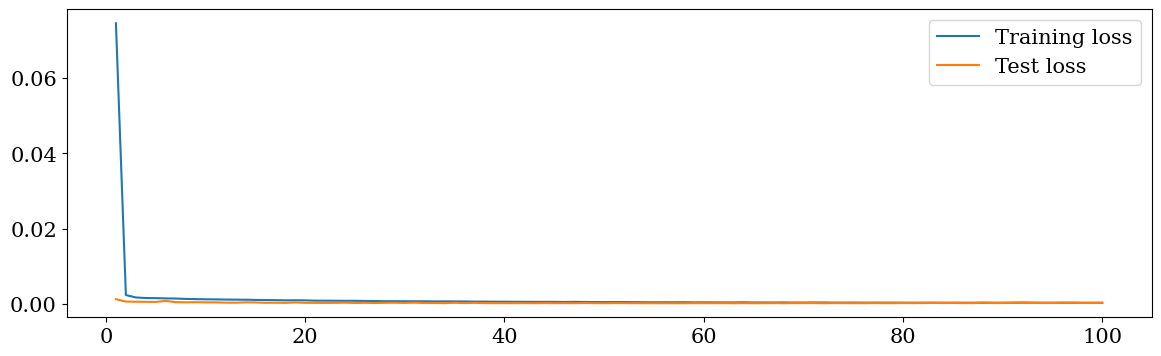

In [ ]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

In [ ]:
# Define the number of future time steps to forecast
num_forecast_steps = 30

# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()

# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]
print(historical_data.shape)

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
	for _ in range(num_forecast_steps):
		# Prepare the historical_data tensor
		historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
		# Use the model to predict the next value
		predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

		# Append the predicted value to the forecasted_values list
		forecasted_values.append(predicted_value)

		# Update the historical_data sequence by removing the oldest value and adding the predicted value
		historical_data = np.roll(historical_data, shift=-1)
		historical_data[-1] = predicted_value

		
# Generate futute indices
last_index = test_data.index[-1]

# Generate the next 30 dates
future_index = pd.Index([last_index + i for i in range(1, 31)])

print(future_index)
# Concatenate the original index with the future dates
combined_index = test_data.index.append(future_index)


(30,)
Int64Index([7000, 7001, 7002, 7003, 7004, 7005, 7006, 7007, 7008, 7009, 7010,
            7011, 7012, 7013, 7014, 7015, 7016, 7017, 7018, 7019, 7020, 7021,
            7022, 7023, 7024, 7025, 7026, 7027, 7028, 7029],
           dtype='int64')


In [ ]:
future_index.shape

(30,)

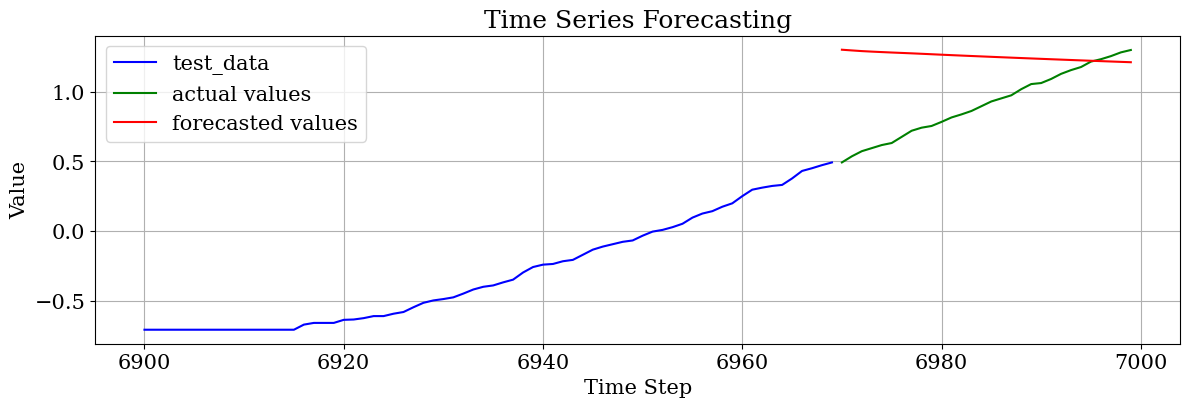

In [ ]:
#set the size of the plot 
plt.rcParams['figure.figsize'] = [14, 4] 


#Test data
plt.plot(test_data.index[-100:-30], test_data.y[-100:-30], label = "test_data", color = "b") 
#reverse the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten() 

#the historical data used as input for forecasting
plt.plot(test_data.index[-30:], original_cases, label='actual values', color='green') 

#Forecasted Values 
#reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 
# plotting the forecasted values
plt.plot(test_data.index[-30:], forecasted_cases, label='forecasted values', color='red') 

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
